In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

from PIL import Image
import cv2

In [3]:
!pip install torchsummary
!pip install Dataloaders

In [4]:
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import models,transforms

#from Dataloaders.HAM10000Dataset import HAM10000Dataset
#from functions import normalization, Model_functions

import time

import random
from PIL import Image
import cv2
import gc
import optuna
import logging

In [5]:
class HAM10000Dataset(Dataset):
    def __init__(self, data, label_column='dx_cat', img_col='image_path', transform=None):
        """
        Custom Dataset for loading HAM10000 images and labels.

        Args:
            data (pd.DataFrame): DataFrame containing image paths and labels.
            label_column (str): Name of the column containing labels.
            img_col (str): Name of the column containing image paths.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data = data.reset_index(drop=True)
        self.label_column = label_column
        self.img_col = img_col
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.data)

    def __getitem__(self, idx):
        """Generates one sample of data."""
        # Get image path
        image_path = self.data.at[idx, self.img_col]

        # Open image
        image = Image.open(image_path).convert('RGB')

        # Get label
        label = self.data.at[idx, self.label_column]
        label = torch.tensor(label, dtype=torch.long)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    return avg_train_loss, train_accuracy

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(val_loader)
    valid_accuracy = 100 * correct / total
    return avg_valid_loss, valid_accuracy

def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy

def train_and_validate_model(model, train_loader, val_loader, test_loader, criterion, patience, optimizer, device, epochs, model_filename, verbose=False):
    min_valid_loss = np.inf

    total_loss_train = []
    total_loss_val = []
    total_acc_train = []
    total_acc_val = []
    stopping_ct = 0

    for epoch in tqdm(range(epochs)):
        if stopping_ct < patience:            
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            valid_loss, valid_acc = validate_epoch(model, val_loader, criterion, device)

            total_loss_train.append(train_loss)
            total_loss_val.append(valid_loss)
            total_acc_train.append(train_acc)
            total_acc_val.append(valid_acc)
            if verbose:
                print(f'Epoch {epoch+1}')
                print(f'Training Loss: {train_loss} \nTraining Accuracy: {train_acc}%')
                print(f'Validation Loss: {valid_loss} \nValidation Accuracy: {valid_acc}%')
                print('=======================================================================')
        if min_valid_loss > valid_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \nSaving The Model')
            print('=======================================================================')
            min_valid_loss = valid_loss
            torch.save(model.state_dict(), model_filename)
            stopping_ct = 0
        else:
            stopping_ct += 1

    best_model_state = torch.load(model_filename)
    model.load_state_dict(best_model_state)
    return model,total_loss_train, total_loss_val, total_acc_train, total_acc_val


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialise_model(model_name, num_classes, feature_extract, use_pretrained=True):
    '''
    grad = if the pretrained weights be updated
    use_pretrained = use pre trained weights or start from scratch
    '''
    model = None
    
    if model_name == 'resnet_pret':
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'densenet_pret':
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    else:
        print("Invalid model name, choose between 'resnet_pret', 'densenet_pret'.")
        exit()
    return model_ft


def conf_report(model_fitted,loader, model_type):
    """
    Generate and display a confusion matrix and a classification report for the predictions made by a model.

    Parameters:
    - model_fitted: The trained model that will be used to make predictions. The model should be compatible
                    with the data provided by the loader and should have a `to` method for device management
                    and an `argmax` method for getting predictions.
    - loader: A data loader that provides batches of data. Each batch should be a tuple containing data
              and its corresponding labels. The loader should be iterable.
    - model_type: A string indicating the type of the model. This is used for labeling purposes
                  when saving the confusion matrix figure.

    The function does the following:
    - Iterates over the provided data loader to collect model predictions and true labels.
    - Computes a confusion matrix both in raw and normalized form.
    - Displays heatmaps for both raw and normalized confusion matrices.
    - Prints a classification report showing main classification metrics.

    Outputs:
    - A figure with two subplots: the left one showing the normalized confusion matrix and the right
      one showing the raw confusion matrix. The figure is saved as 'Confusion_Matrix_{model_type}.png'.
    - A printed classification report in the console.
    """
    y_pred = []
    y_true = []
    for data, target in loader:
        data, target = data.to('cpu'), target.to('cpu')
        model_cpu = model_fitted.to('cpu')
        output = model_cpu(data)
        y_pred.extend(output.argmax(dim=1).tolist())
        y_true.extend(target.tolist())
    
    classes = [ 'bkl','nv','df','mel','vasc','bcc','akiec']

    cf_matrix = confusion_matrix(y_true, y_pred)
    df_temp = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, np.newaxis], index=classes, columns=classes)

    plt.figure(figsize=(24, 10))  

    plt.subplot(1, 2, 1)  
    sns.heatmap(df_temp, annot=True, fmt=".3f", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    plt.subplot(1, 2, 2)  
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Raw Confusion Matrix')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    plt.savefig(f'Confusion_Matrix_{model_type}.png')
    plt.show()

    report = classification_report(y_true, y_pred, target_names=classes)
    print('-------------------------------------------------------')
    print("Classification Report:\n")
    print(report)
    print('-------------------------------------------------------')

In [7]:
data = pd.read_csv('/kaggle/input/cnn-unbalanced/data_unbalanced.csv')
data = data.sample(frac=1)
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dup_les,image_path,dx_cat
1078,HAM_0006658,ISIC_0026154,bcc,histo,85,male,neck,False,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,5
14518,HAM_0000183,ISIC_0027764,nv,follow_up,45,male,lower extremity,False,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,1
13296,HAM_0002385,ISIC_0024549,nv,follow_up,65,male,trunk,False,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,1
13544,HAM_0001341,ISIC_0025191,nv,follow_up,45,male,trunk,False,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,1
2980,HAM_0003361,ISIC_0033234,nv,consensus,45,female,unknown,False,/kaggle/input/skin-cancer-mnist-ham10000/HAM10...,1


In [8]:
img_h, img_w = 224, 224

norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [9]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=transform)
test_dataset = HAM10000Dataset(test_data, transform=transform)

In [10]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data len Train: 6616 Val: 6617 Test: 3309


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [12]:
model_temp = 'densenet_pret'
num_classes = 7
feature_extract = False
model_des = initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_des.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 152MB/s] 


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [13]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_des.parameters(), lr=1e-3)
input_size = (3, 224, 224)
#print(summary(model_des, input_size, device=device.type))

In [14]:
start_time = time.time()

In [15]:
epochs = 30
patience = 5
model_filename = '/kaggle/working/densenet_pret.pth'
densenet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = train_and_validate_model(
                        model_des, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename,verbose=True)

  3%|▎         | 1/30 [01:55<55:45, 115.37s/it]

Epoch 1
Training Loss: 0.5897208924454768 
Training Accuracy: 81.1819830713422%
Validation Loss: 0.5360711594134713 
Validation Accuracy: 80.88257518512921%
Validation Loss Decreased(inf--->0.536071) 
Saving The Model


  7%|▋         | 2/30 [03:55<55:15, 118.40s/it]

Epoch 2
Training Loss: 0.5169042517309603 
Training Accuracy: 82.31559854897219%
Validation Loss: 0.47334416988103284 
Validation Accuracy: 84.04110624149916%
Validation Loss Decreased(0.536071--->0.473344) 
Saving The Model


 10%|█         | 3/30 [05:56<53:48, 119.57s/it]

Epoch 3
Training Loss: 0.4700868307536351 
Training Accuracy: 83.2073760580411%
Validation Loss: 0.4635829475622822 
Validation Accuracy: 84.1771195405773%
Validation Loss Decreased(0.473344--->0.463583) 
Saving The Model


 13%|█▎        | 4/30 [07:57<51:57, 119.90s/it]

Epoch 4
Training Loss: 0.44276660428818876 
Training Accuracy: 83.67593712212818%
Validation Loss: 0.4012243745551593 
Validation Accuracy: 86.02085537252532%
Validation Loss Decreased(0.463583--->0.401224) 
Saving The Model


 17%|█▋        | 5/30 [09:58<50:05, 120.24s/it]

Epoch 5
Training Loss: 0.4156677610992234 
Training Accuracy: 85.29322853688029%
Validation Loss: 0.37887705768939955 
Validation Accuracy: 86.79159740063473%
Validation Loss Decreased(0.401224--->0.378877) 
Saving The Model


 20%|██        | 6/30 [11:58<48:07, 120.31s/it]

Epoch 6
Training Loss: 0.41900428568107495 
Training Accuracy: 85.14207980652962%
Validation Loss: 0.4122917043486079 
Validation Accuracy: 85.20477557805653%


 23%|██▎       | 7/30 [13:59<46:09, 120.39s/it]

Epoch 7
Training Loss: 0.3814313834812042 
Training Accuracy: 86.06408706166869%
Validation Loss: 0.3720907248592607 
Validation Accuracy: 86.9124981109264%
Validation Loss Decreased(0.378877--->0.372091) 
Saving The Model


 27%|██▋       | 8/30 [15:59<44:10, 120.47s/it]

Epoch 8
Training Loss: 0.3746868222951889 
Training Accuracy: 86.57799274486095%
Validation Loss: 0.3493565070816284 
Validation Accuracy: 87.83436602690041%
Validation Loss Decreased(0.372091--->0.349357) 
Saving The Model


 30%|███       | 9/30 [18:00<42:10, 120.51s/it]

Epoch 9
Training Loss: 0.35083316309728485 
Training Accuracy: 87.15235792019347%
Validation Loss: 0.37492492495347624 
Validation Accuracy: 87.00317364364516%


 33%|███▎      | 10/30 [20:00<40:08, 120.43s/it]

Epoch 10
Training Loss: 0.34719652725734573 
Training Accuracy: 87.71160822249094%
Validation Loss: 0.32189878438046016 
Validation Accuracy: 88.27263110170772%
Validation Loss Decreased(0.349357--->0.321899) 
Saving The Model


 37%|███▋      | 11/30 [22:00<38:06, 120.35s/it]

Epoch 11
Training Loss: 0.3377183445409876 
Training Accuracy: 87.9081015719468%
Validation Loss: 0.3153049868446041 
Validation Accuracy: 88.49931993350461%
Validation Loss Decreased(0.321899--->0.315305) 
Saving The Model


 40%|████      | 12/30 [24:00<36:03, 120.21s/it]

Epoch 12
Training Loss: 0.3067162298925833 
Training Accuracy: 88.99637243047158%
Validation Loss: 0.34336523202378394 
Validation Accuracy: 88.40864440078586%


 43%|████▎     | 13/30 [26:01<34:04, 120.27s/it]

Epoch 13
Training Loss: 0.32253753822206876 
Training Accuracy: 88.61850060459493%
Validation Loss: 0.4127345304702215 
Validation Accuracy: 87.00317364364516%


 47%|████▋     | 14/30 [28:00<32:01, 120.09s/it]

Epoch 14
Training Loss: 0.28500671677543343 
Training Accuracy: 89.91837968561065%
Validation Loss: 0.3176409395024684 
Validation Accuracy: 89.57231373734321%


 50%|█████     | 15/30 [30:01<30:02, 120.15s/it]

Epoch 15
Training Loss: 0.2834222422381818 
Training Accuracy: 89.46493349455865%
Validation Loss: 0.26636844873428345 
Validation Accuracy: 90.29771799909325%
Validation Loss Decreased(0.315305--->0.266368) 
Saving The Model


 53%|█████▎    | 16/30 [32:01<28:02, 120.18s/it]

Epoch 16
Training Loss: 0.2601723458779895 
Training Accuracy: 90.20556227327691%
Validation Loss: 0.2950015377235297 
Validation Accuracy: 89.7990025691401%


 57%|█████▋    | 17/30 [34:01<26:01, 120.09s/it]

Epoch 17
Training Loss: 0.2693550338707684 
Training Accuracy: 90.2962515114873%
Validation Loss: 0.257040542014987 
Validation Accuracy: 90.88710896176515%
Validation Loss Decreased(0.266368--->0.257041) 
Saving The Model


 60%|██████    | 18/30 [36:01<24:01, 120.09s/it]

Epoch 18
Training Loss: 0.24854555470500014 
Training Accuracy: 90.99153567110037%
Validation Loss: 0.2410654304864038 
Validation Accuracy: 91.03823484962975%
Validation Loss Decreased(0.257041--->0.241065) 
Saving The Model


 63%|██████▎   | 19/30 [38:00<21:58, 119.87s/it]

Epoch 19
Training Loss: 0.23294550488176552 
Training Accuracy: 91.4752116082225%
Validation Loss: 0.2854534735912142 
Validation Accuracy: 90.0559165785099%


 67%|██████▋   | 20/30 [39:59<19:56, 119.62s/it]

Epoch 20
Training Loss: 0.2284171362430001 
Training Accuracy: 91.91354292623942%
Validation Loss: 0.26985797100668946 
Validation Accuracy: 89.99546622336406%


 70%|███████   | 21/30 [41:59<17:57, 119.74s/it]

Epoch 21
Training Loss: 0.22672088541414426 
Training Accuracy: 91.76239419588876%
Validation Loss: 0.22774610708913076 
Validation Accuracy: 92.14145383104126%
Validation Loss Decreased(0.241065--->0.227746) 
Saving The Model


 73%|███████▎  | 22/30 [43:59<15:57, 119.68s/it]

Epoch 22
Training Loss: 0.2060974436915583 
Training Accuracy: 92.56348246674727%
Validation Loss: 0.2792623464854947 
Validation Accuracy: 91.03823484962975%


 77%|███████▋  | 23/30 [45:58<13:56, 119.57s/it]

Epoch 23
Training Loss: 0.2029398829554734 
Training Accuracy: 92.77509068923821%
Validation Loss: 0.22191663168298736 
Validation Accuracy: 92.36814266283814%
Validation Loss Decreased(0.227746--->0.221917) 
Saving The Model


 80%|████████  | 24/30 [47:58<11:58, 119.75s/it]

Epoch 24
Training Loss: 0.19862211890212725 
Training Accuracy: 92.77509068923821%
Validation Loss: 0.21754097795464855 
Validation Accuracy: 92.56460631706211%
Validation Loss Decreased(0.221917--->0.217541) 
Saving The Model


 83%|████████▎ | 25/30 [49:57<09:57, 119.58s/it]

Epoch 25
Training Loss: 0.1946609133431589 
Training Accuracy: 92.98669891172914%
Validation Loss: 0.22441979075651525 
Validation Accuracy: 92.1263412422548%


 87%|████████▋ | 26/30 [51:57<07:58, 119.58s/it]

Epoch 26
Training Loss: 0.19644011481516604 
Training Accuracy: 93.2285368802902%
Validation Loss: 0.1969696368104306 
Validation Accuracy: 93.51669941060904%
Validation Loss Decreased(0.217541--->0.196970) 
Saving The Model


 90%|█████████ | 27/30 [53:56<05:58, 119.36s/it]

Epoch 27
Training Loss: 0.18047800240813247 
Training Accuracy: 93.2738814993954%
Validation Loss: 0.2051690603732379 
Validation Accuracy: 92.80640773764546%


 93%|█████████▎| 28/30 [55:55<03:58, 119.41s/it]

Epoch 28
Training Loss: 0.16732145893131045 
Training Accuracy: 94.25634824667473%
Validation Loss: 0.2385036287298381 
Validation Accuracy: 91.47649992443705%


 97%|█████████▋| 29/30 [57:55<01:59, 119.43s/it]

Epoch 29
Training Loss: 0.1595344495361194 
Training Accuracy: 94.48307134220073%
Validation Loss: 0.23967339799869897 
Validation Accuracy: 92.06589088710896%


100%|██████████| 30/30 [59:54<00:00, 119.83s/it]

Epoch 30
Training Loss: 0.16421622025289973 
Training Accuracy: 94.16565900846433%
Validation Loss: 0.24579191148497057 
Validation Accuracy: 91.47649992443705%



/tmp/ipykernel_30/944843552.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load(model_filename)


In [16]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for the Resnet Pretrainned Model: {total_time/60:.2f} minutes")
elapsed_time = end_time - start_time

Total training and validation time for the Resnet Pretrainned Model: 59.92 minutes


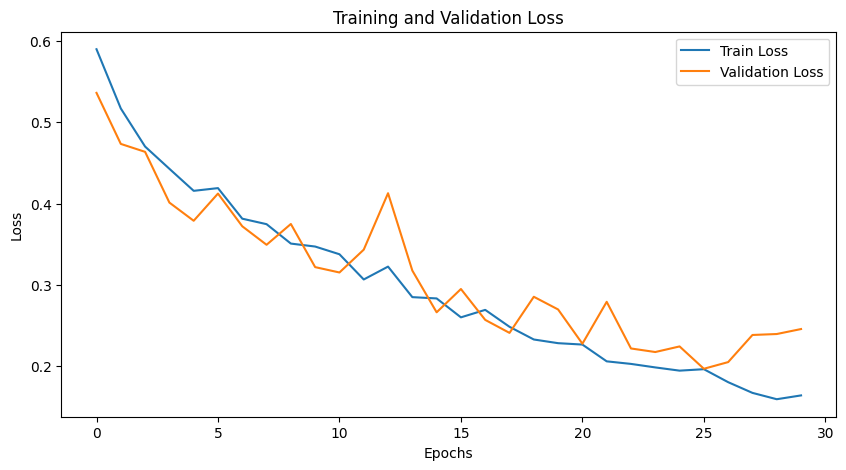

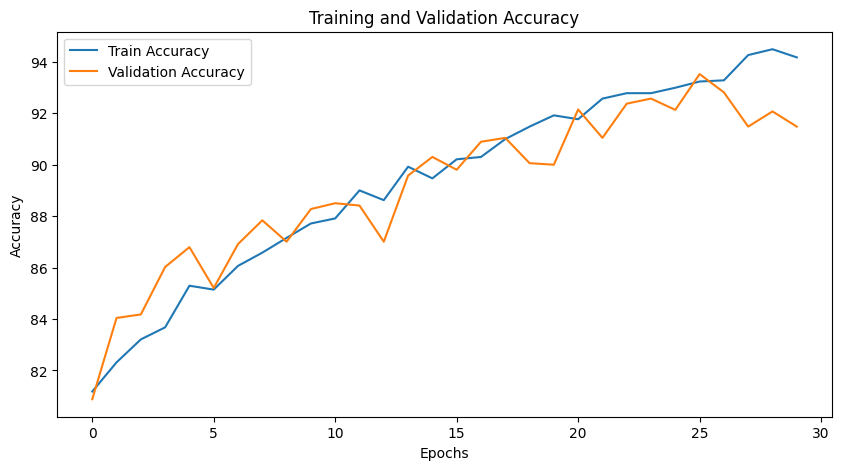

In [17]:
# Plot training and validation loss
plt.figure(figsize=(10,5))
plt.plot(total_loss_train, label='Train Loss')
plt.plot(total_loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10,5))
plt.plot(total_acc_train, label='Train Accuracy')
plt.plot(total_acc_val, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
best_model_state = torch.load('densenet_pret.pth',map_location='cpu')
device = torch.device('cpu')
model_des.load_state_dict(best_model_state)
model_des.to(device)
test_accuracy = test_model(model_des, test_loader, device)
print('-------------------------------------------------------')
print(f'Best models accuracy {test_accuracy}')
print('-------------------------------------------------------')


/tmp/ipykernel_30/1813673769.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_state = torch.load('densenet_pret.pth',map_location='cpu')


-------------------------------------------------------
Best models accuracy 93.29102447869447
-------------------------------------------------------


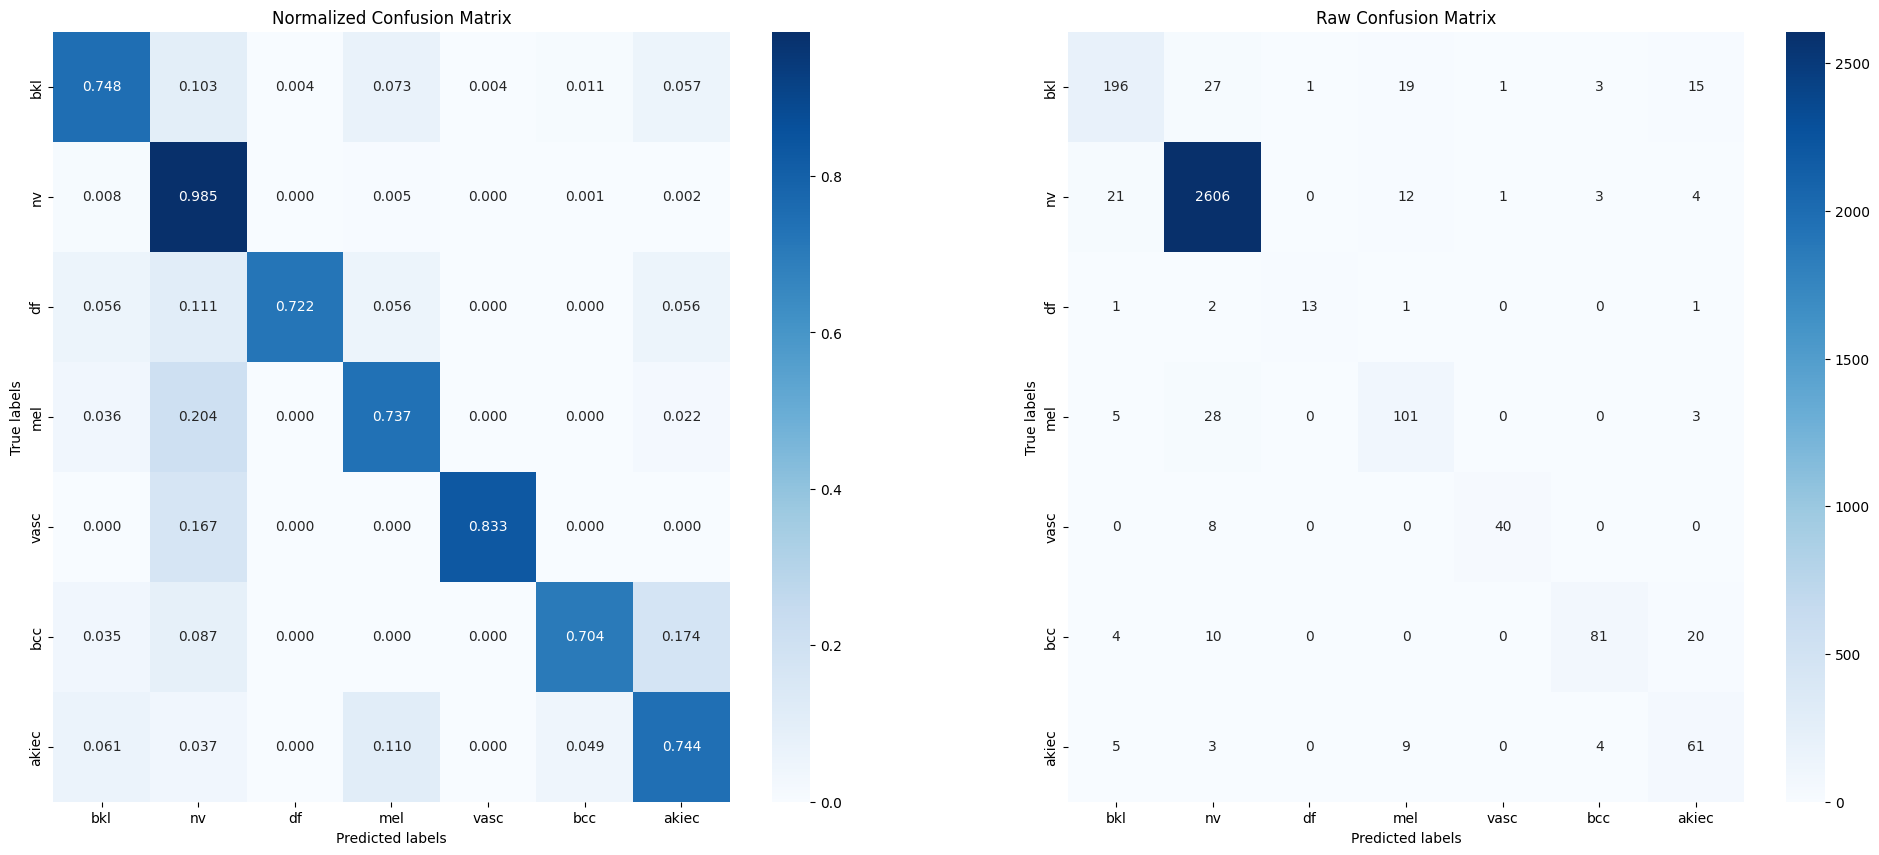

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.84      0.75      0.79       262
          nv       0.97      0.98      0.98      2647
          df       0.93      0.72      0.81        18
         mel       0.71      0.74      0.72       137
        vasc       0.95      0.83      0.89        48
         bcc       0.89      0.70      0.79       115
       akiec       0.59      0.74      0.66        82

    accuracy                           0.94      3309
   macro avg       0.84      0.78      0.81      3309
weighted avg       0.94      0.94      0.94      3309

-------------------------------------------------------


In [19]:
conf_report(model_des, test_loader, 'densenet_conf_mat')
